# 20230511 - Determining region level clustering 

1. Calculate lobm scargle on padded regions with known assignments
2. Total power per joint within region (proboscis, locomotion, idle, etc)
* Bar graph for total power
* Threshold for things that aren’t actually moving

3. Threshold each node (Slack)
4. All by all distance claculation (frame by frame)
* Normalized but thresholded
* Unnormalized but thresholded
* Unnormalized no threshold

5. Generate distance matrix
* Distance matrix with dendrogram

In [1]:
import os
import h5py
import numpy as np
from scipy.io import loadmat
import logging
import pickle

# Setting up proper logging
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler())

wavelets_file = "/Genomics/ayroleslab2/scott/git/lts-manuscript/analysis/notebooks/data/wavelet_results.pickle"
wavelet_results = pickle.load(open(wavelets_file, "rb"))

In [2]:
wavelet_results

{'idle': {0: array([[1.03605057e+00, 9.00377533e-01, 9.63867824e-01, ...,
          6.25345291e-31, 3.93591988e-30, 4.47941194e-30],
         [1.03563804e+00, 9.13147466e-01, 9.81423423e-01, ...,
          4.66383052e-31, 3.53847686e-30, 4.06365103e-31],
         [1.03535162e+00, 9.26168456e-01, 9.99654871e-01, ...,
          3.27918063e-30, 5.17758460e-30, 4.92127132e-30],
         ...,
         [1.01726504e+00, 1.05213458e+00, 8.15868367e-01, ...,
          7.66319234e-31, 3.08428061e-31, 1.33679900e-31],
         [1.00380632e+00, 1.03439873e+00, 7.91270858e-01, ...,
          3.20159636e-31, 1.31382631e-31, 6.72641155e-31],
         [9.89240913e-01, 1.01461095e+00, 7.66738136e-01, ...,
          4.25935567e-31, 6.04486987e-32, 2.50872776e-31]]),
  1: array([[1.53800367e+00, 2.00439614e-01, 5.05203305e-02, ...,
          4.18256332e-31, 1.81164028e-31, 4.10709851e-31],
         [1.59314274e+00, 2.01160350e-01, 5.50978009e-02, ...,
          3.38964922e-31, 1.90065641e-31, 3.12240572e

In [3]:
average_total_power_per_node = {}

# Iterate over each behavior
for behavior, behavior_wavelets in wavelet_results.items():
    logger.info(f"Aggregating wavelets for behavior {behavior}")
    wlets = np.concatenate(list(behavior_wavelets.values()), axis=0)
    wlets = np.abs(wlets) ** 2  # Power
    # wlets[wlets < 1e7] = 0 # Thresholding
    
    total_power_per_node = []

    # Calculate power per node for each set of wavelets
    for wavelet in behavior_wavelets.values():
        power = np.abs(wavelet) ** 2

        # Sum over the frames axis (0th dimension, as power shape is (frames, nodes*freqs))
        total_power = np.sum(power, axis=0)
        
        # Reshape to separate node and frequency dimensions (assuming number of nodes is 24 and freqs is 25)
        total_power = total_power.reshape(-1, 24, 25)

        # Sum over the frequency axis to get total power per node
        total_power_per_node.append(np.sum(total_power, axis=2))

    # Average over all wavelet sets for the behavior
    average_total_power = np.mean(total_power_per_node, axis=0)

    average_total_power_per_node[behavior] = average_total_power

Aggregating wavelets for behavior idle
Aggregating wavelets for behavior loco
Aggregating wavelets for behavior proboscis
Aggregating wavelets for behavior fore_groom
Aggregating wavelets for behavior hind_groom


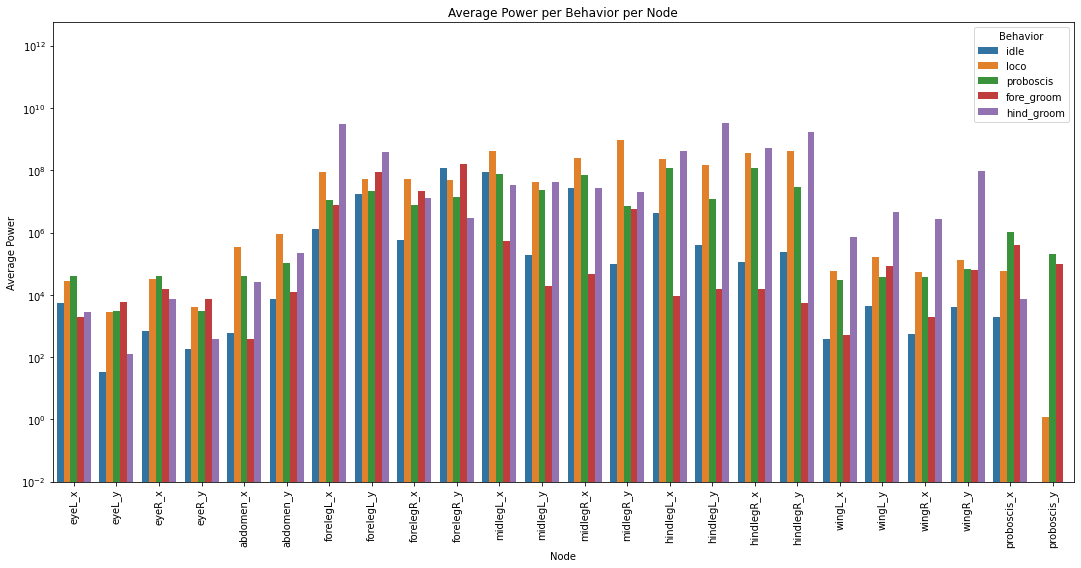

In [4]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Node names
node_names = ['eyeL_x', 'eyeL_y', 'eyeR_x', 'eyeR_y', 'abdomen_x', 'abdomen_y', 'forelegL_x', 'forelegL_y', 'forelegR_x', 'forelegR_y', 'midlegL_x',
              'midlegL_y', 'midlegR_x', 'midlegR_y', 'hindlegL_x', 'hindlegL_y', 'hindlegR_x', 'hindlegR_y', 'wingL_x', 'wingL_y', 'wingR_x', 'wingR_y', 'proboscis_x', 'proboscis_y']

# Prepare data for seaborn
data = []
for behavior, powers in average_total_power_per_node.items():
    for node_name, power in zip(node_names, powers.flatten()):
        data.append([behavior, node_name, power])

df = pd.DataFrame(data, columns=["Behavior", "Node", "Average Power"])

# Plot
plt.figure(figsize=(15, 8))
sns.barplot(data=df, x="Node", y="Average Power", hue="Behavior")
plt.title('Average Power per Behavior per Node')
plt.ylabel('Average Power')
plt.xlabel('Node')
plt.xticks(rotation=90)
plt.tight_layout()
plt.yscale('log')
plt.ylim(1e-2)
plt.savefig('figures/power_per_behavior_per_node.jpg')
plt.show()

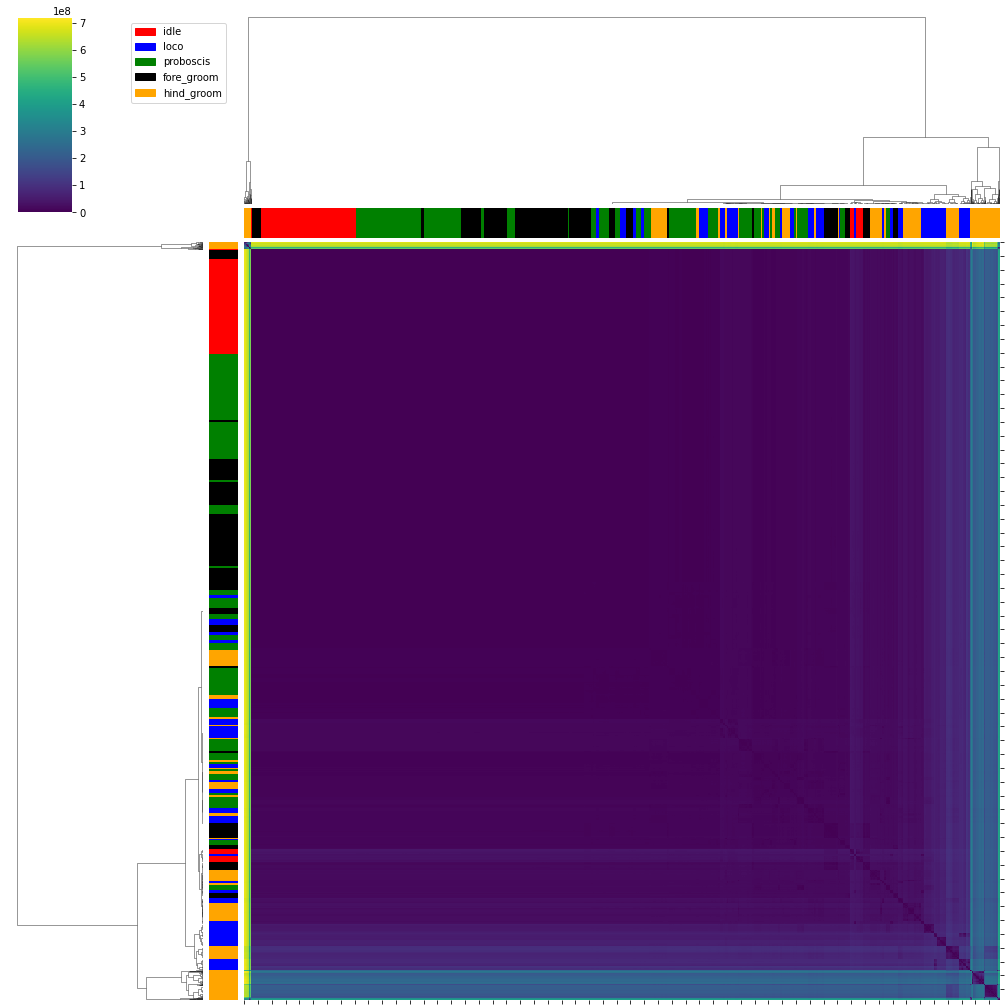

In [5]:
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage

# concatenate all wavelets from all behaviors and keep track of behavior assignments
all_wavelets = []
behavior_labels = []
for behavior, behavior_wavelets in wavelet_results.items():
    for wavelet in behavior_wavelets.values():
        all_wavelets.append(wavelet)
        behavior_labels.append(behavior)
        
behavior_labels = []
for behavior, behavior_wavelets in wavelet_results.items():
    for wavelet in behavior_wavelets.values():
        behavior_labels += [behavior] * wavelet.shape[0]

# stack all wavelets into a 2D array (frames x frequencies)
all_wavelets = np.vstack(all_wavelets)

# Commented out -- previously was randomly sampling 100 frames from each behavior
# sample_ids = np.random.choice(np.arange(all_wavelets.shape[0]), size=100, replace=False)
# all_wavelets = all_wavelets[sample_ids, :]
# behavior_labels = np.array(behavior_labels)[sample_ids]

# calculate power spectra
power_spectra = np.abs(all_wavelets) ** 2

# compute pairwise distances between power spectra of each frame
color_dict = {'idle': 'red', 'loco': 'blue', 'proboscis': 'green','fore_groom':"black", 'hind_groom': 'orange'}
label_colors = [color_dict[label] for label in behavior_labels]

dist_matrix = pd.DataFrame(squareform(pdist(power_spectra)), columns=behavior_labels, index=behavior_labels)

g = sns.clustermap(dist_matrix, method='average', cmap='viridis', figsize=(15, 15), row_colors=label_colors, col_colors=label_colors)
ax = g.ax_heatmap
ax.set_xticklabels('')
ax.set_yticklabels('')

import matplotlib.patches as mpatches

# Create a legend for the color mapping
legend_patches = [mpatches.Patch(color=color, label=behavior) for behavior, color in color_dict.items()]

plt.legend(handles=legend_patches, bbox_to_anchor=(2, 1), loc='upper left')

plt.savefig('figures/clustermap_tieredls_nonormalization_nothreshold.jpg')


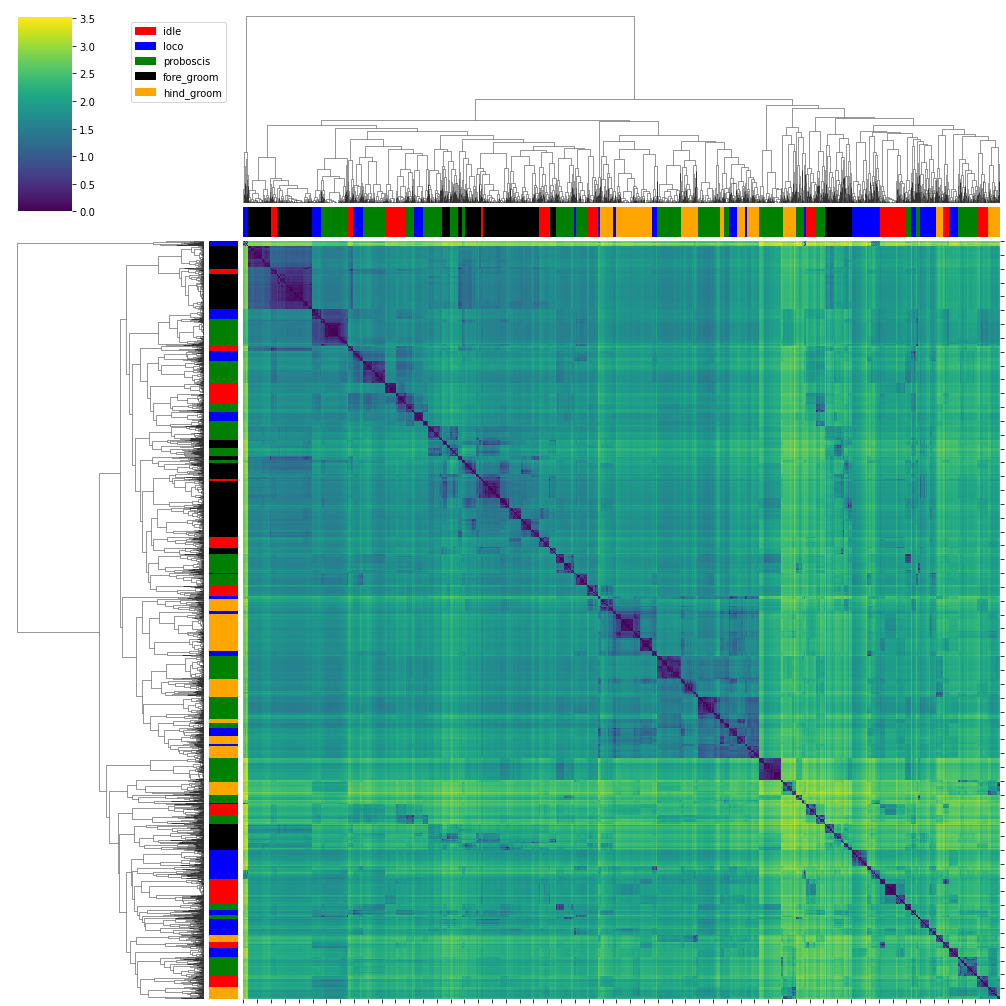

In [6]:
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage

# concatenate all wavelets from all behaviors and keep track of behavior assignments
all_wavelets = []
behavior_labels = []
for behavior, behavior_wavelets in wavelet_results.items():
    for wavelet in behavior_wavelets.values():
        all_wavelets.append(wavelet)
        behavior_labels.append(behavior)
        
behavior_labels = []
for behavior, behavior_wavelets in wavelet_results.items():
    for wavelet in behavior_wavelets.values():
        behavior_labels += [behavior] * wavelet.shape[0]

# stack all wavelets into a 2D array (frames x frequencies)
all_wavelets = np.vstack(all_wavelets)

row_maxes = all_wavelets.max(axis=1)
# Reshape row_maxes to make it compatible for division
row_maxes = row_maxes.reshape(-1, 1)
# Divide each row by its maximum value
all_wavelets = all_wavelets / row_maxes

# Commented out -- previously was randomly sampling 100 frames from each behavior
# sample_ids = np.random.choice(np.arange(all_wavelets.shape[0]), size=100, replace=False)
# all_wavelets = all_wavelets[sample_ids, :]
# behavior_labels = np.array(behavior_labels)[sample_ids]

# calculate power spectra
power_spectra = np.abs(all_wavelets) ** 2

# compute pairwise distances between power spectra of each frame
color_dict = {'idle': 'red', 'loco': 'blue', 'proboscis': 'green','fore_groom':"black", 'hind_groom': 'orange'}
label_colors = [color_dict[label] for label in behavior_labels]

dist_matrix = pd.DataFrame(squareform(pdist(power_spectra)), columns=behavior_labels, index=behavior_labels)

g = sns.clustermap(dist_matrix, method='average', cmap='viridis', figsize=(15, 15), row_colors=label_colors, col_colors=label_colors)
ax = g.ax_heatmap
ax.set_xticklabels('')
ax.set_yticklabels('')

import matplotlib.patches as mpatches

# Create a legend for the color mapping
legend_patches = [mpatches.Patch(color=color, label=behavior) for behavior, color in color_dict.items()]

plt.legend(handles=legend_patches, bbox_to_anchor=(2, 1), loc='upper left')

plt.savefig('figures/clustermap_tieredls_normalization_nothreshold.jpg')


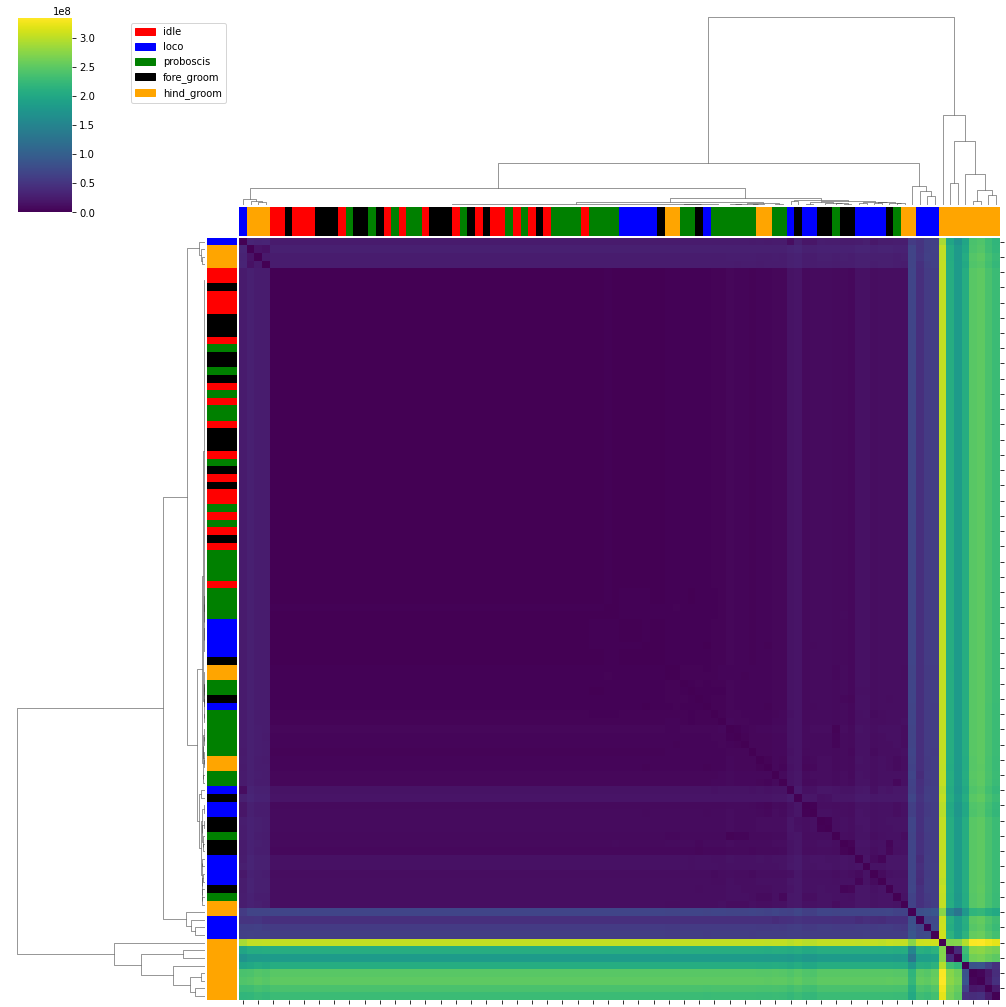

In [9]:
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage

# concatenate all wavelets from all behaviors and keep track of behavior assignments
all_wavelets = []
behavior_labels = []
for behavior, behavior_wavelets in wavelet_results.items():
    for wavelet in behavior_wavelets.values():
        all_wavelets.append(wavelet)
        behavior_labels.append(behavior)
        
behavior_labels = []
for behavior, behavior_wavelets in wavelet_results.items():
    for wavelet in behavior_wavelets.values():
        behavior_labels += [behavior] * wavelet.shape[0]

# stack all wavelets into a 2D array (frames x frequencies)
all_wavelets = np.vstack(all_wavelets)#[0:1000,:]
# behavior_labels = behavior_labels[0:1000]

# Calculate the sum of each node


# row_maxes = all_wavelets.max(axis=1)
# Reshape row_maxes to make it compatible for division
# row_maxes = row_maxes.reshape(-1, 1)
# Divide each row by its maximum value
# all_wavelets = all_wavelets / row_maxes

# Commented out -- previously was randomly sampling 100 frames from each behavior
sample_ids = np.random.choice(np.arange(all_wavelets.shape[0]), size=100, replace=False)
all_wavelets = all_wavelets[sample_ids, :]
behavior_labels = np.array(behavior_labels)[sample_ids]

# calculate power spectra
power_spectra = np.abs(all_wavelets) ** 2
power_spectra_reshaped = power_spectra.reshape(-1, 24, 25)
node_sums = power_spectra_reshaped.sum(axis=-1)

# Create a boolean mask for nodes with total power less than 1e7
mask = node_sums < 1e6

# Use broadcasting to apply the mask across the last dimension (the 25 elements in each node)
for i in range(power_spectra_reshaped.shape[0]):
    power_spectra_reshaped[i][mask[i]] = 0

# Reshape back to original shape
power_spectra = power_spectra_reshaped.reshape(-1, 600)

# compute pairwise distances between power spectra of each frame
color_dict = {'idle': 'red', 'loco': 'blue', 'proboscis': 'green','fore_groom':"black", 'hind_groom': 'orange'}
label_colors = [color_dict[label] for label in behavior_labels]

dist_matrix = pd.DataFrame(squareform(pdist(power_spectra)), columns=behavior_labels, index=behavior_labels)
dist_matrix[np.isnan(dist_matrix)] = 0
g = sns.clustermap(dist_matrix, method='average', cmap='viridis', figsize=(15, 15), row_colors=label_colors, col_colors=label_colors)
ax = g.ax_heatmap
ax.set_xticklabels('')
ax.set_yticklabels('')

import matplotlib.patches as mpatches

# Create a legend for the color mapping
legend_patches = [mpatches.Patch(color=color, label=behavior) for behavior, color in color_dict.items()]

plt.legend(handles=legend_patches, bbox_to_anchor=(2, 1), loc='upper left')

plt.savefig('figures/clustermap_tieredls_normalization_threshold.jpg')


In [8]:
node_sums.astype(int)

array([[1289,   60,  580, ..., 2845, 2225,    9],
       [ 127,  807, 1621, ..., 1449,   10,    0],
       [1007,  172, 1625, ..., 1001, 3665,    0],
       ...,
       [  76,    7,   54, ..., 1607,  114,    1],
       [  15,    5,    2, ...,  289,    6,    0],
       [ 185,  669, 2830, ..., 6738,    9,    0]])